# 01 — Exploratory Data Analysis (EDA)

This notebook explores the structure and characteristics of the Drug Usage Detection dataset.
We inspect missing values, class distribution, and text properties.

In [1]:
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import watermark
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_nb

%load_ext watermark
%matplotlib inline

nltk.download('stopwords')

RANDOM_SEED = 333
np.random.seed(RANDOM_SEED)
tqdm.pandas()
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lhbelfanti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.0
IPython version      : 9.10.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 25.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 04d0bf935632822ae01e75fa6175171aa294c4b5

sys       : 3.13.0 (main, Nov 30 2024, 02:51:51) [Clang 16.0.0 (clang-1600.0.26.4)]
watermark : 2.5.0
matplotlib: 3.10.8
platform  : 1.0.8
seaborn   : 0.13.2
numpy     : 2.4.2
tqdm      : 4.67.3
pandas    : 3.0.0
re        : 2.2.1
IPython   : 9.10.0
nltk      : 3.9.2



In [3]:
plt.style.use('../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

---
## 1. Load Data

In [4]:
CORPUS_NAME = 'raw-corpus' # Options: 'pre-filtered-corpus', 'raw-corpus'
RAW_DATA_PATH = f'../data/raw/{CORPUS_NAME}.csv'
df = pd.read_csv(RAW_DATA_PATH)
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()

Dataset loaded: 3000 rows × 12 columns


,ID,TweetAuthor,TweetAvatar,TweetText,TweetImages,IsTweetAReply,QuoteAuthor,QuoteAvatar,QuoteText,QuoteImages,IsQuoteAReply,Categorization
0,17411,@juulibut,https://pbs.twimg.com/profile_images/149232575...,Necesito un porro,NaN,False,NaN,NaN,NaN,NaN,NaN,POSITIVE
1,15207,@pire_vai,https://pbs.twimg.com/profile_images/148920055...,Tengo Tanto Frío que voy a tomar una Raya de R...,NaN,False,NaN,NaN,NaN,NaN,NaN,NEGATIVE
2,15208,@juliankaxeres,https://pbs.twimg.com/profile_images/180614150...,"Bueno, el vecino que escuchaba Perdiendo el Co...",NaN,False,NaN,NaN,NaN,NaN,NaN,NEGATIVE
3,15209,@percapita_mano,https://pbs.twimg.com/profile_images/147441449...,Sabes cuantos se van a tomar una raya en honor...,NaN,False,NaN,NaN,NaN,NaN,NaN,NEGATIVE
4,15210,@Santinhooo13,https://pbs.twimg.com/profile_images/134510339...,El mejor en el velorio de Maradona fue el que ...,NaN,False,NaN,NaN,NaN,NaN,NaN,NEGATIVE


## 2. Basic Inspection

In [5]:
print(df.info())
print("\nMissing values per column:")
display(df.isnull().sum())

<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              3000 non-null   int64 
 1   TweetAuthor     3000 non-null   str   
 2   TweetAvatar     3000 non-null   str   
 3   TweetText       3000 non-null   str   
 4   TweetImages     910 non-null    str   
 5   IsTweetAReply   3000 non-null   bool  
 6   QuoteAuthor     44 non-null     str   
 7   QuoteAvatar     44 non-null     str   
 8   QuoteText       36 non-null     str   
 9   QuoteImages     16 non-null     str   
 10  IsQuoteAReply   44 non-null     object
 11  Categorization  3000 non-null   str   
dtypes: bool(1), int64(1), object(1), str(9)
memory usage: 260.9+ KB
None

Missing values per column:


ID                   0
TweetAuthor          0
TweetAvatar          0
TweetText            0
TweetImages       2090
IsTweetAReply        0
QuoteAuthor       2956
QuoteAvatar       2956
QuoteText         2964
QuoteImages       2984
IsQuoteAReply     2956
Categorization       0
dtype: int64

### Keep relevant columns
`TweetText` (the raw text) and `Categorization` (the label).

In [6]:
df_clean = df[['TweetText', 'Categorization']].copy()
df_clean.rename(columns={'TweetText': 'text', 'Categorization': 'label'}, inplace=True)
df_clean.head()

,text,label
0,Necesito un porro,POSITIVE
1,Tengo Tanto Frío que voy a tomar una Raya de R...,NEGATIVE
2,"Bueno, el vecino que escuchaba Perdiendo el Co...",NEGATIVE
3,Sabes cuantos se van a tomar una raya en honor...,NEGATIVE
4,El mejor en el velorio de Maradona fue el que ...,NEGATIVE


## 3. Text Length Analysis

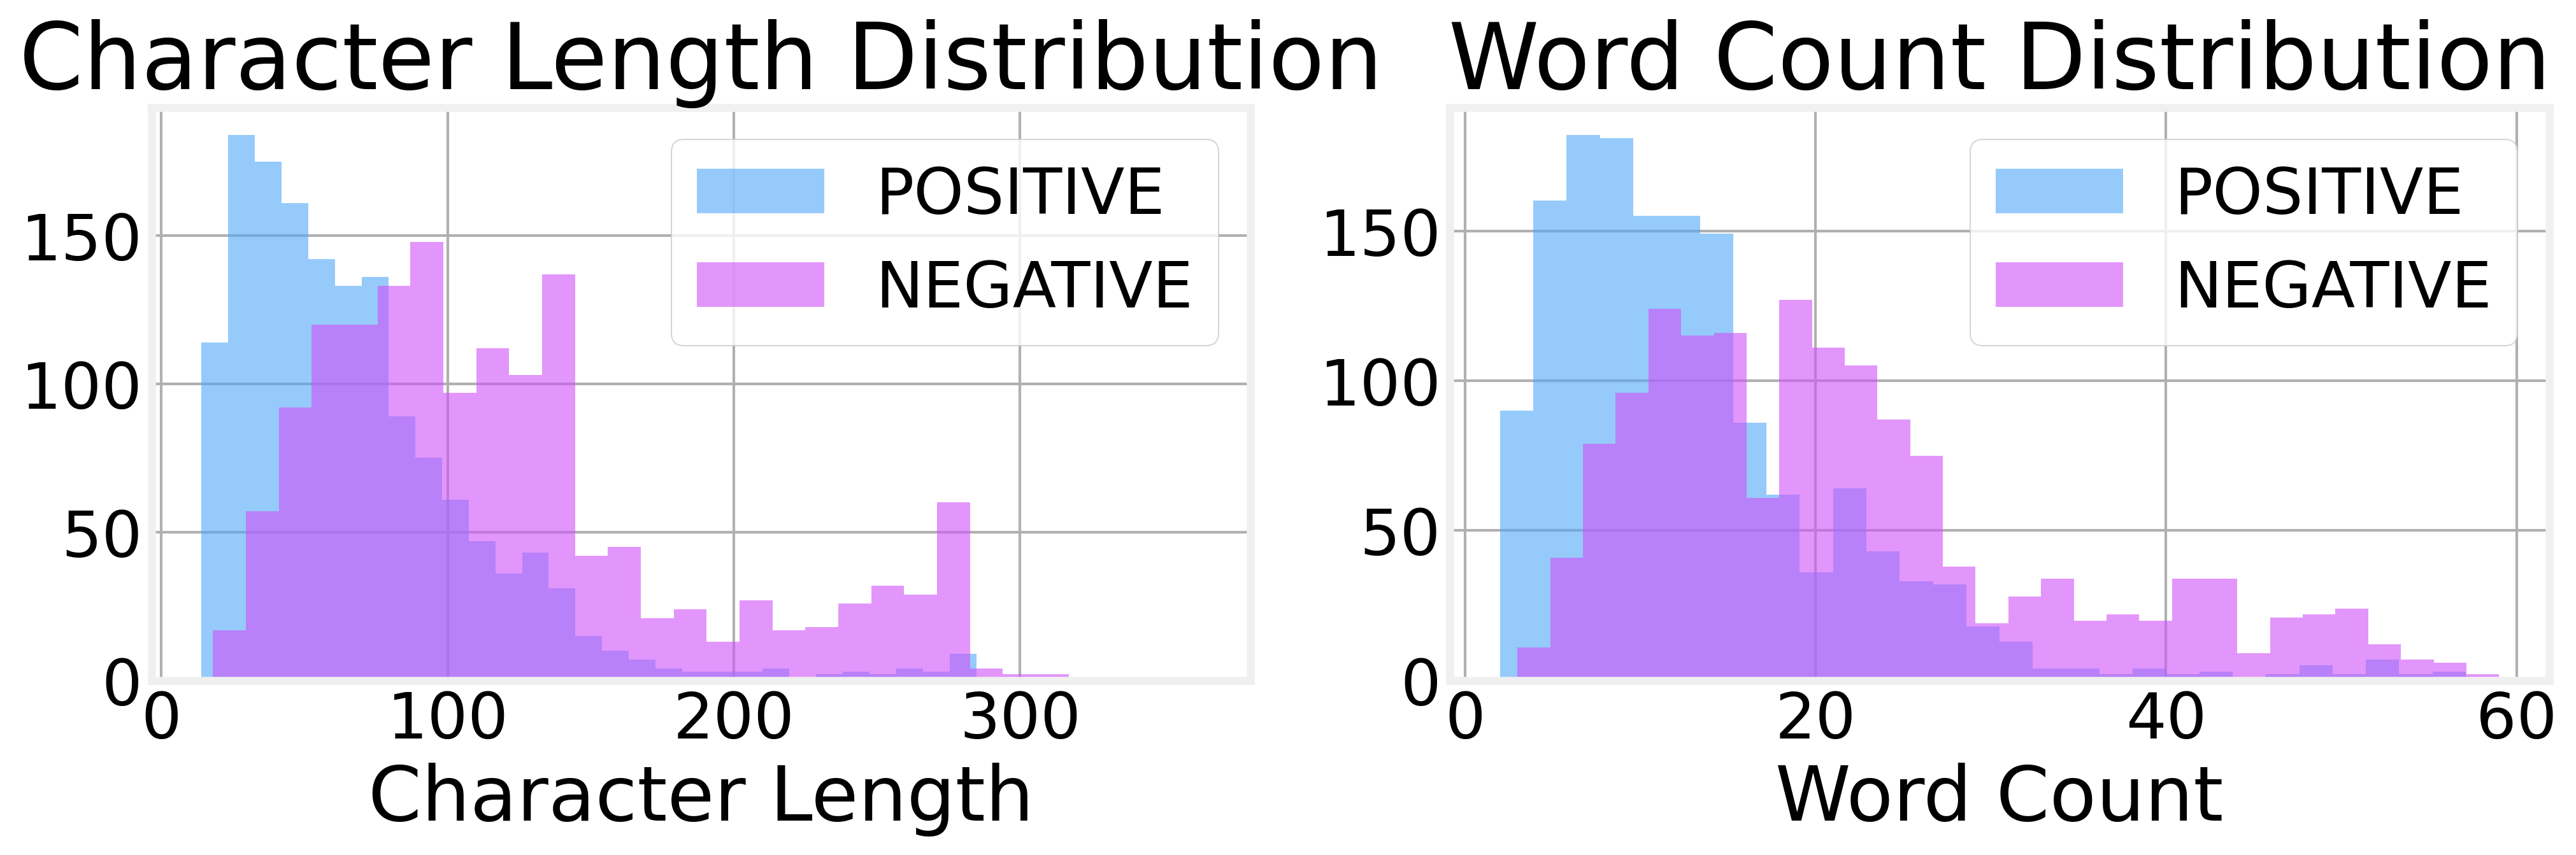

         char_length                                                          \
               count        mean        std   min   25%    50%    75%    max   
label                                                                          
NEGATIVE      1500.0  120.647333  66.111639  18.0  72.0  106.0  142.0  363.0   
POSITIVE      1500.0   68.562667  44.550120  14.0  36.0   59.0   87.0  294.0   

         word_count                                                     
              count       mean        std  min   25%   50%   75%   max  
label                                                                   
NEGATIVE     1500.0  21.818667  11.913595  3.0  13.0  19.0  27.0  59.0  
POSITIVE     1500.0  13.056667   8.732867  2.0   7.0  11.0  17.0  59.0  


In [7]:
df_clean['char_length'] = df_clean['text'].astype(str).apply(len)
df_clean['word_count'] = df_clean['text'].astype(str).apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for label, color in zip(df_clean['label'].unique(), colors[:2]):
    subset = df_clean[df_clean['label'] == label]
    axes[0].hist(subset['char_length'], bins=30, alpha=0.6, label=label, color=color)
    axes[1].hist(subset['word_count'], bins=30, alpha=0.6, label=label, color=color)

axes[0].set_title('Character Length Distribution')
axes[0].set_xlabel('Character Length')
axes[0].legend()

axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Word Count')
axes[1].legend()

plt.tight_layout()
plt.show()

print(df_clean.groupby('label')[['char_length', 'word_count']].describe())

## 4. Most Common Words
Top words per class after removing Spanish stop words.

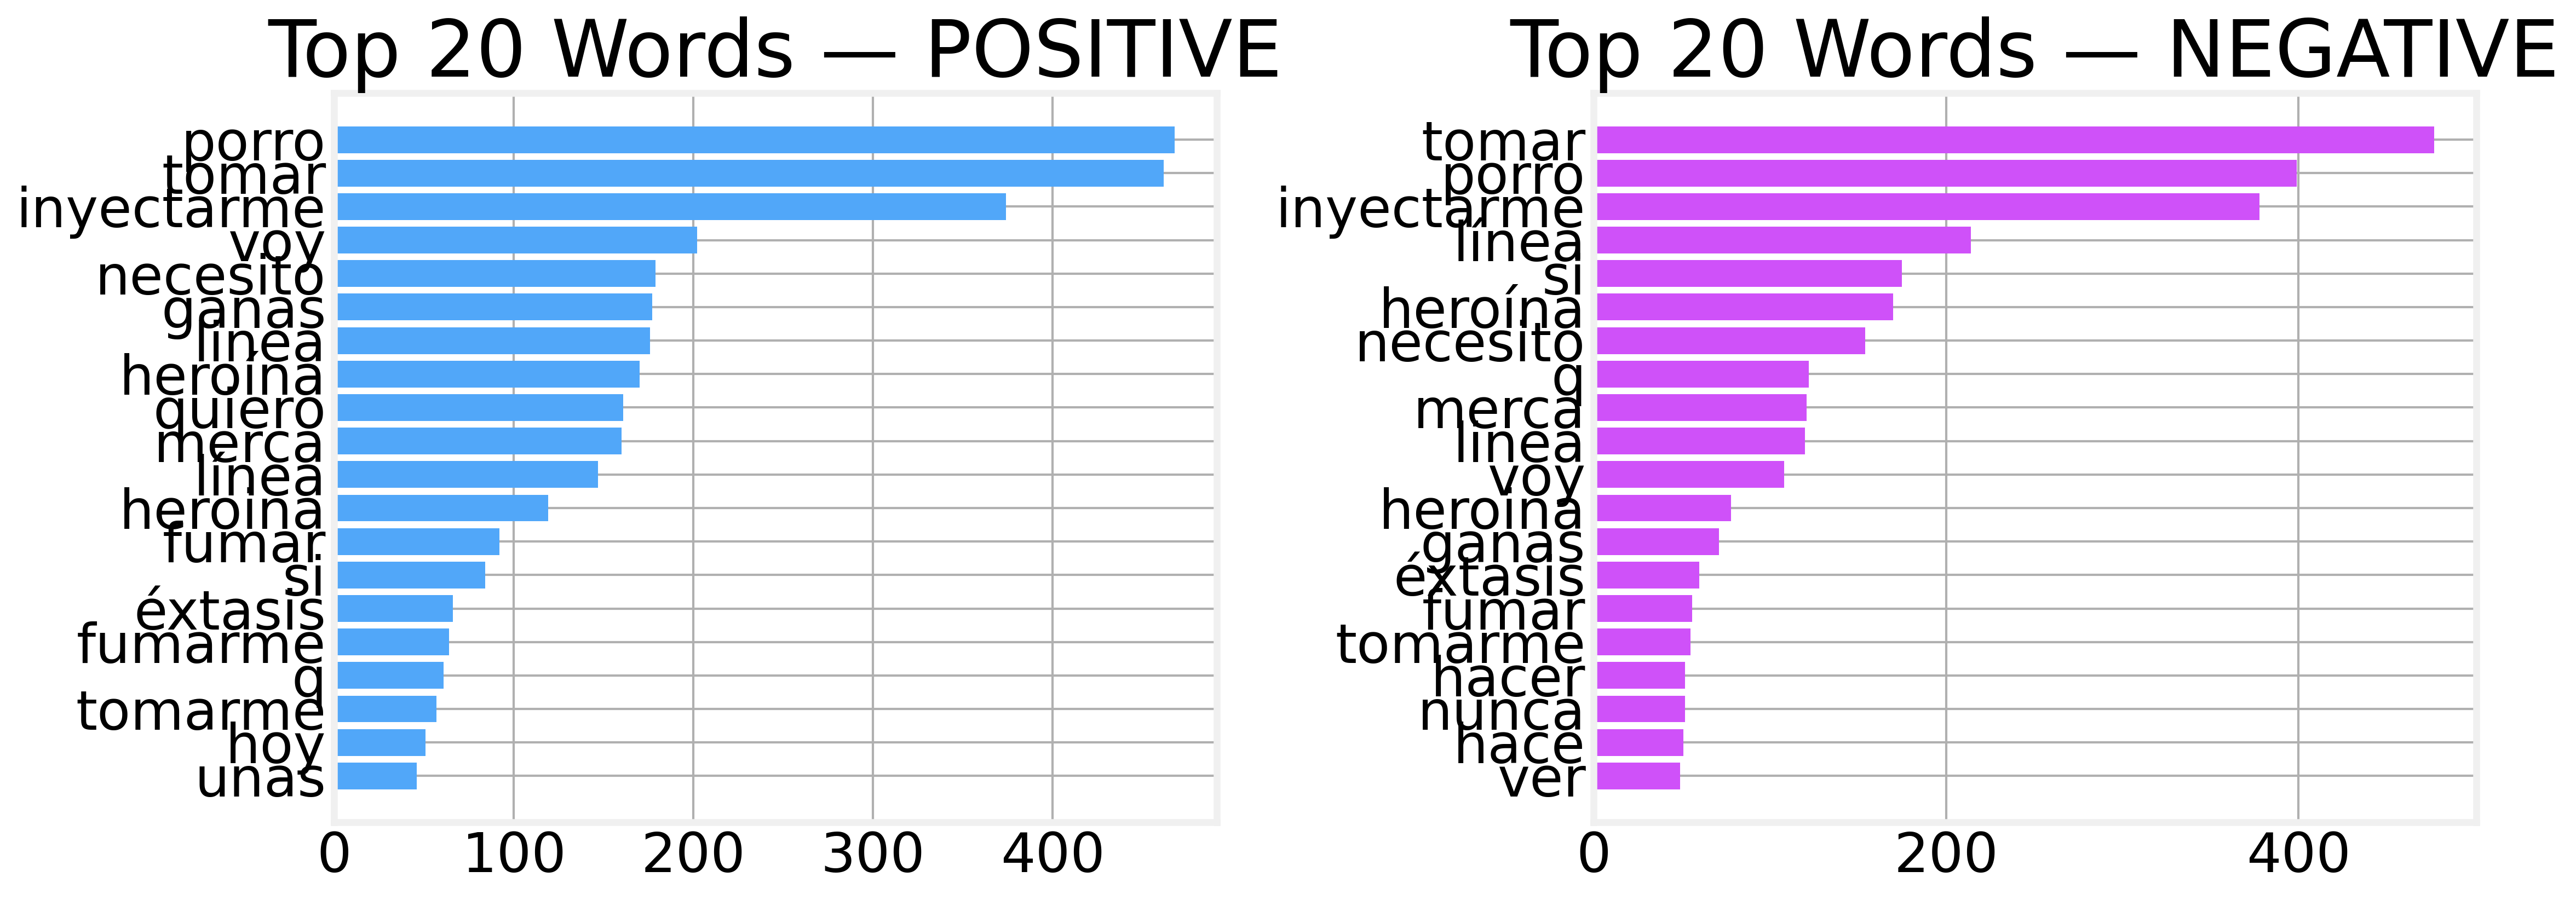

In [8]:
def get_top_words(texts, n=20):
    """Extract the n most common words from a series of texts, excluding stop words."""
    words = []
    for text in texts:
        tokens = str(text).lower().split()
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        words.extend(tokens)
    return Counter(words).most_common(n)

positive_words = get_top_words(df_clean[df_clean['label'] == 'POSITIVE']['text'])
negative_words = get_top_words(df_clean[df_clean['label'] == 'NEGATIVE']['text'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# POSITIVE class
words_p, counts_p = zip(*positive_words)
axes[0].barh(words_p[::-1], counts_p[::-1], color=colors[0])
axes[0].set_title('Top 20 Words — POSITIVE')

# NEGATIVE class
words_n, counts_n = zip(*negative_words)
axes[1].barh(words_n[::-1], counts_n[::-1], color=colors[1])
axes[1].set_title('Top 20 Words — NEGATIVE')

plt.tight_layout()
plt.show()

As we can see and as it was expected, the main words are drug-related terminology.

## 4. Named Entity Recognition (NER)

We use Spacy to identify entities (Persons, Locations, Organizations) in the text.

In [9]:
import re
import spacy
from collections import Counter

try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("Downloading model...")
    from spacy.cli import download
    download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

def strip_obfuscation_tags(text):
    """Remove obfuscation tags like [ANATOMIA], [GROSERIA], etc. before NER processing."""
    return re.sub(r'\[([A-Z_]+)\]', '', text)

def get_entities(text):
    cleaned = strip_obfuscation_tags(text)
    doc = nlp(cleaned)
    return [(ent.text, ent.label_) for ent in doc.ents]

all_entities = []
for text in tqdm(df['TweetText']):
    all_entities.extend(get_entities(text))

entity_counts = Counter(all_entities)
print("Top 20 Entities:")
for ent, count in entity_counts.most_common(20):
    print(f"{ent}: {count}")

  0%|                       | 0/3000 [00:00<?, ?it/s]

  0%|               | 6/3000 [00:00<00:56, 52.59it/s]

  0%|              | 15/3000 [00:00<00:41, 72.69it/s]

  1%|              | 23/3000 [00:00<00:39, 75.70it/s]

  1%|▏             | 31/3000 [00:00<00:38, 77.24it/s]

  1%|▏             | 39/3000 [00:00<00:41, 70.66it/s]

  2%|▏             | 47/3000 [00:00<00:40, 73.59it/s]

  2%|▎             | 55/3000 [00:00<00:43, 68.23it/s]

  2%|▎             | 63/3000 [00:00<00:41, 70.30it/s]

  2%|▎             | 72/3000 [00:00<00:38, 75.40it/s]

  3%|▍             | 83/3000 [00:01<00:34, 83.53it/s]

  3%|▍             | 92/3000 [00:01<00:34, 84.63it/s]

  3%|▍            | 101/3000 [00:01<00:34, 83.32it/s]

  4%|▍            | 111/3000 [00:01<00:32, 87.57it/s]

  4%|▌            | 120/3000 [00:01<00:32, 87.29it/s]

  4%|▌            | 129/3000 [00:01<00:35, 81.69it/s]

  5%|▌            | 139/3000 [00:01<00:33, 86.45it/s]

  5%|▋            | 149/3000 [00:01<00:33, 86.18it/s]

  5%|▋            | 158/3000 [00:01<00:32, 86.45it/s]

  6%|▋            | 168/3000 [00:02<00:32, 88.24it/s]

  6%|▊            | 177/3000 [00:02<00:32, 87.07it/s]

  6%|▊            | 186/3000 [00:02<00:33, 84.16it/s]

  7%|▊            | 196/3000 [00:02<00:32, 87.24it/s]

  7%|▉            | 206/3000 [00:02<00:32, 86.68it/s]

  7%|▉            | 215/3000 [00:02<00:33, 83.39it/s]

  8%|▉            | 225/3000 [00:02<00:31, 87.79it/s]

  8%|█            | 236/3000 [00:02<00:29, 93.14it/s]

  8%|█            | 247/3000 [00:02<00:28, 97.38it/s]

  9%|█           | 258/3000 [00:03<00:27, 100.68it/s]

  9%|█           | 270/3000 [00:03<00:26, 104.35it/s]

  9%|█           | 281/3000 [00:03<00:25, 104.58it/s]

 10%|█▏          | 292/3000 [00:03<00:26, 103.55it/s]

 10%|█▏          | 304/3000 [00:03<00:25, 106.09it/s]

 10%|█▎          | 315/3000 [00:03<00:25, 106.28it/s]

 11%|█▎          | 327/3000 [00:03<00:25, 106.87it/s]

 11%|█▎          | 338/3000 [00:03<00:25, 104.52it/s]

 12%|█▍          | 349/3000 [00:03<00:25, 105.49it/s]

 12%|█▍          | 360/3000 [00:04<00:25, 105.33it/s]

 12%|█▍          | 371/3000 [00:04<00:25, 101.84it/s]

 13%|█▌          | 382/3000 [00:04<00:25, 101.05it/s]

 13%|█▌          | 393/3000 [00:04<00:25, 100.44it/s]

 14%|█▌          | 405/3000 [00:04<00:24, 104.26it/s]

 14%|█▊           | 416/3000 [00:04<00:38, 67.70it/s]

 14%|█▊           | 425/3000 [00:04<00:36, 70.85it/s]

 15%|█▉           | 438/3000 [00:04<00:30, 83.02it/s]

 15%|█▉           | 450/3000 [00:05<00:27, 91.26it/s]

 15%|██           | 462/3000 [00:05<00:25, 98.08it/s]

 16%|█▉          | 473/3000 [00:05<00:25, 100.36it/s]

 16%|█▉          | 484/3000 [00:05<00:24, 102.95it/s]

 17%|█▉          | 497/3000 [00:05<00:23, 108.46it/s]

 17%|██          | 510/3000 [00:05<00:21, 113.78it/s]

 17%|██          | 522/3000 [00:05<00:21, 114.77it/s]

 18%|██▏         | 534/3000 [00:05<00:21, 115.80it/s]

 18%|██▏         | 547/3000 [00:05<00:20, 117.04it/s]

 19%|██▏         | 559/3000 [00:06<00:21, 111.72it/s]

 19%|██▎         | 571/3000 [00:06<00:23, 101.32it/s]

 19%|██▌          | 582/3000 [00:06<00:26, 92.45it/s]

 20%|██▌          | 592/3000 [00:06<00:27, 88.39it/s]

 20%|██▌          | 602/3000 [00:06<00:28, 84.74it/s]

 20%|██▋          | 611/3000 [00:06<00:28, 84.64it/s]

 21%|██▋          | 620/3000 [00:06<00:27, 85.49it/s]

 21%|██▋          | 629/3000 [00:06<00:28, 81.84it/s]

 21%|██▊          | 638/3000 [00:06<00:28, 82.63it/s]

 22%|██▊          | 648/3000 [00:07<00:27, 87.07it/s]

 22%|██▊          | 658/3000 [00:07<00:26, 89.89it/s]

 22%|██▉          | 668/3000 [00:07<00:25, 92.31it/s]

 23%|██▉          | 679/3000 [00:07<00:24, 95.39it/s]

 23%|██▉          | 690/3000 [00:07<00:23, 98.30it/s]

 23%|██▊         | 701/3000 [00:07<00:22, 100.73it/s]

 24%|███          | 712/3000 [00:07<00:22, 99.67it/s]

 24%|███▏         | 722/3000 [00:07<00:22, 99.27it/s]

 24%|███▏         | 732/3000 [00:07<00:23, 98.09it/s]

 25%|███▏         | 742/3000 [00:08<00:23, 96.28it/s]

 25%|███▎         | 752/3000 [00:08<00:23, 95.91it/s]

 25%|███▎         | 762/3000 [00:08<00:23, 94.83it/s]

 26%|███▎         | 772/3000 [00:08<00:23, 94.31it/s]

 26%|███▍         | 783/3000 [00:08<00:23, 95.94it/s]

 26%|███▍         | 793/3000 [00:08<00:23, 95.61it/s]

 27%|███▍         | 803/3000 [00:08<00:23, 95.49it/s]

 27%|███▌         | 813/3000 [00:08<00:23, 94.59it/s]

 27%|███▌         | 823/3000 [00:08<00:23, 94.47it/s]

 28%|███▌         | 833/3000 [00:09<00:22, 95.90it/s]

 28%|███▋         | 843/3000 [00:09<00:22, 97.05it/s]

 28%|███▋         | 853/3000 [00:09<00:22, 96.26it/s]

 29%|███▋         | 863/3000 [00:09<00:22, 94.84it/s]

 29%|███▊         | 873/3000 [00:09<00:22, 94.70it/s]

 29%|███▊         | 883/3000 [00:09<00:22, 93.55it/s]

 30%|███▊         | 893/3000 [00:09<00:22, 94.73it/s]

 30%|███▉         | 903/3000 [00:09<00:23, 90.40it/s]

 30%|███▉         | 913/3000 [00:09<00:23, 90.19it/s]

 31%|███▉         | 923/3000 [00:09<00:22, 90.66it/s]

 31%|████         | 933/3000 [00:10<00:22, 90.33it/s]

 32%|████         | 945/3000 [00:10<00:21, 96.21it/s]

 32%|████▏        | 956/3000 [00:10<00:21, 97.10it/s]

 32%|████▏        | 966/3000 [00:10<00:21, 96.83it/s]

 33%|████▏        | 977/3000 [00:10<00:20, 98.24it/s]

 33%|███▉        | 989/3000 [00:10<00:19, 102.63it/s]

 33%|████        | 1000/3000 [00:10<00:20, 98.50it/s]

 34%|███▋       | 1012/3000 [00:10<00:19, 104.23it/s]

 34%|███▊       | 1023/3000 [00:10<00:18, 105.48it/s]

 34%|███▊       | 1034/3000 [00:11<00:18, 105.09it/s]

 35%|███▊       | 1046/3000 [00:11<00:18, 107.34it/s]

 35%|███▉       | 1057/3000 [00:11<00:18, 104.54it/s]

 36%|████▎       | 1068/3000 [00:11<00:22, 84.86it/s]

 36%|████▎       | 1078/3000 [00:11<00:21, 87.86it/s]

 36%|████▎       | 1088/3000 [00:11<00:21, 90.51it/s]

 37%|████▍       | 1098/3000 [00:11<00:21, 89.22it/s]

 37%|████▍       | 1108/3000 [00:11<00:21, 89.65it/s]

 37%|████▍       | 1118/3000 [00:12<00:20, 91.13it/s]

 38%|████▌       | 1128/3000 [00:12<00:20, 91.91it/s]

 38%|████▌       | 1138/3000 [00:12<00:19, 93.68it/s]

 38%|████▌       | 1148/3000 [00:12<00:19, 93.59it/s]

 39%|████▋       | 1160/3000 [00:12<00:18, 98.74it/s]

 39%|████▎      | 1171/3000 [00:12<00:18, 100.47it/s]

 39%|████▎      | 1182/3000 [00:12<00:17, 102.61it/s]

 40%|████▎      | 1193/3000 [00:12<00:17, 103.97it/s]

 40%|████▍      | 1205/3000 [00:12<00:16, 105.94it/s]

 41%|████▍      | 1216/3000 [00:12<00:16, 105.78it/s]

 41%|████▍      | 1227/3000 [00:13<00:16, 106.32it/s]

 41%|████▌      | 1239/3000 [00:13<00:16, 105.36it/s]

 42%|████▌      | 1250/3000 [00:13<00:17, 102.15it/s]

 42%|████▌      | 1261/3000 [00:13<00:17, 100.43it/s]

 42%|████▋      | 1272/3000 [00:13<00:16, 102.46it/s]

 43%|█████▏      | 1283/3000 [00:13<00:17, 99.89it/s]

 43%|████▋      | 1294/3000 [00:13<00:16, 102.05it/s]

 44%|████▊      | 1306/3000 [00:13<00:16, 104.07it/s]

 44%|████▊      | 1317/3000 [00:13<00:16, 102.77it/s]

 44%|█████▎      | 1328/3000 [00:14<00:16, 98.79it/s]

 45%|████▉      | 1339/3000 [00:14<00:16, 100.04it/s]

 45%|█████▍      | 1350/3000 [00:14<00:18, 88.94it/s]

 45%|█████▍      | 1361/3000 [00:14<00:17, 93.20it/s]

 46%|█████▍      | 1372/3000 [00:14<00:17, 95.49it/s]

 46%|█████▌      | 1383/3000 [00:14<00:16, 97.47it/s]

 46%|█████      | 1394/3000 [00:14<00:15, 100.62it/s]

 47%|█████▏     | 1405/3000 [00:14<00:15, 102.21it/s]

 47%|█████▋      | 1416/3000 [00:14<00:16, 95.38it/s]

 48%|█████▋      | 1426/3000 [00:15<00:16, 93.31it/s]

 48%|█████▋      | 1436/3000 [00:15<00:17, 88.91it/s]

 48%|█████▊      | 1445/3000 [00:15<00:17, 87.61it/s]

 48%|█████▊      | 1454/3000 [00:15<00:18, 82.37it/s]

 49%|█████▊      | 1463/3000 [00:15<00:19, 78.84it/s]

 49%|█████▉      | 1471/3000 [00:15<00:20, 74.97it/s]

 49%|█████▉      | 1479/3000 [00:15<00:20, 75.21it/s]

 50%|█████▉      | 1488/3000 [00:15<00:19, 77.69it/s]

 50%|█████▉      | 1496/3000 [00:16<00:19, 77.15it/s]

 50%|██████      | 1506/3000 [00:16<00:18, 81.40it/s]

 51%|██████      | 1517/3000 [00:16<00:17, 86.22it/s]

 51%|██████      | 1526/3000 [00:16<00:17, 84.80it/s]

 51%|██████▏     | 1535/3000 [00:16<00:17, 84.93it/s]

 51%|██████▏     | 1544/3000 [00:16<00:17, 84.51it/s]

 52%|██████▏     | 1553/3000 [00:16<00:18, 78.26it/s]

 52%|██████▏     | 1561/3000 [00:16<00:18, 77.35it/s]

 52%|██████▎     | 1569/3000 [00:16<00:18, 77.60it/s]

 53%|██████▎     | 1578/3000 [00:17<00:18, 77.77it/s]

 53%|██████▎     | 1586/3000 [00:17<00:18, 77.45it/s]

 53%|██████▍     | 1595/3000 [00:17<00:17, 78.60it/s]

 53%|██████▍     | 1603/3000 [00:17<00:18, 77.29it/s]

 54%|██████▍     | 1611/3000 [00:17<00:18, 76.12it/s]

 54%|██████▍     | 1619/3000 [00:17<00:18, 74.76it/s]

 54%|██████▌     | 1627/3000 [00:17<00:19, 71.25it/s]

 55%|██████▌     | 1635/3000 [00:17<00:19, 69.74it/s]

 55%|██████▌     | 1643/3000 [00:17<00:19, 68.36it/s]

 55%|██████▌     | 1653/3000 [00:18<00:17, 75.13it/s]

 55%|██████▋     | 1661/3000 [00:18<00:18, 73.58it/s]

 56%|██████▋     | 1669/3000 [00:18<00:17, 74.38it/s]

 56%|██████▋     | 1678/3000 [00:18<00:17, 76.33it/s]

 56%|██████▋     | 1687/3000 [00:18<00:16, 77.93it/s]

 56%|██████▊     | 1695/3000 [00:18<00:16, 78.44it/s]

 57%|██████▊     | 1705/3000 [00:18<00:15, 81.35it/s]

 57%|██████▊     | 1714/3000 [00:18<00:15, 81.39it/s]

 57%|██████▉     | 1724/3000 [00:18<00:14, 85.77it/s]

 58%|██████▉     | 1734/3000 [00:19<00:14, 88.55it/s]

 58%|██████▉     | 1743/3000 [00:19<00:14, 86.75it/s]

 58%|███████     | 1753/3000 [00:19<00:13, 90.33it/s]

 59%|███████     | 1763/3000 [00:19<00:13, 88.95it/s]

 59%|███████     | 1772/3000 [00:19<00:13, 88.94it/s]

 59%|███████     | 1781/3000 [00:19<00:14, 84.16it/s]

 60%|███████▏    | 1790/3000 [00:19<00:14, 83.78it/s]

 60%|███████▏    | 1800/3000 [00:19<00:13, 86.55it/s]

 60%|███████▏    | 1809/3000 [00:19<00:13, 86.96it/s]

 61%|███████▎    | 1818/3000 [00:19<00:13, 86.18it/s]

 61%|███████▎    | 1827/3000 [00:20<00:13, 85.10it/s]

 61%|███████▎    | 1836/3000 [00:20<00:13, 85.33it/s]

 62%|███████▍    | 1845/3000 [00:20<00:13, 83.68it/s]

 62%|███████▍    | 1855/3000 [00:20<00:13, 85.55it/s]

 62%|███████▍    | 1864/3000 [00:20<00:13, 84.39it/s]

 62%|███████▍    | 1873/3000 [00:20<00:13, 81.60it/s]

 63%|███████▌    | 1882/3000 [00:20<00:13, 80.31it/s]

 63%|███████▌    | 1892/3000 [00:20<00:13, 84.54it/s]

 63%|███████▌    | 1901/3000 [00:20<00:13, 82.02it/s]

 64%|███████▋    | 1910/3000 [00:21<00:13, 83.67it/s]

 64%|███████▋    | 1920/3000 [00:21<00:12, 85.93it/s]

 64%|███████▋    | 1930/3000 [00:21<00:12, 88.25it/s]

 65%|███████▊    | 1942/3000 [00:21<00:11, 95.05it/s]

 65%|███████▊    | 1953/3000 [00:21<00:10, 99.07it/s]

 65%|███████▏   | 1964/3000 [00:21<00:10, 102.15it/s]

 66%|███████▏   | 1976/3000 [00:21<00:09, 105.43it/s]

 66%|███████▎   | 1987/3000 [00:21<00:09, 105.99it/s]

 67%|███████▎   | 1999/3000 [00:21<00:09, 107.63it/s]

 67%|████████    | 2010/3000 [00:22<00:14, 70.31it/s]

 67%|████████    | 2020/3000 [00:22<00:12, 76.43it/s]

 68%|████████    | 2031/3000 [00:22<00:11, 83.82it/s]

 68%|████████▏   | 2042/3000 [00:22<00:10, 90.22it/s]

 68%|████████▏   | 2052/3000 [00:22<00:10, 89.21it/s]

 69%|████████▎   | 2063/3000 [00:22<00:10, 92.51it/s]

 69%|████████▎   | 2074/3000 [00:22<00:09, 95.39it/s]

 70%|████████▎   | 2086/3000 [00:22<00:09, 99.56it/s]

 70%|███████▋   | 2097/3000 [00:23<00:08, 100.47it/s]

 70%|████████▍   | 2108/3000 [00:23<00:09, 95.47it/s]

 71%|████████▍   | 2118/3000 [00:23<00:09, 93.03it/s]

 71%|████████▌   | 2128/3000 [00:23<00:09, 93.99it/s]

 71%|████████▌   | 2138/3000 [00:23<00:09, 93.92it/s]

 72%|████████▌   | 2149/3000 [00:23<00:08, 96.94it/s]

 72%|███████▉   | 2161/3000 [00:23<00:08, 102.19it/s]

 72%|███████▉   | 2172/3000 [00:23<00:07, 104.39it/s]

 73%|████████   | 2184/3000 [00:23<00:07, 106.48it/s]

 73%|████████   | 2197/3000 [00:24<00:07, 110.98it/s]

 74%|████████   | 2209/3000 [00:24<00:07, 109.29it/s]

 74%|████████▏  | 2220/3000 [00:24<00:07, 106.79it/s]

 74%|████████▏  | 2231/3000 [00:24<00:07, 106.74it/s]

 75%|████████▏  | 2243/3000 [00:24<00:06, 108.38it/s]

 75%|████████▎  | 2254/3000 [00:24<00:07, 103.81it/s]

 76%|████████▎  | 2266/3000 [00:24<00:06, 107.07it/s]

 76%|████████▎  | 2278/3000 [00:24<00:06, 109.30it/s]

 76%|████████▍  | 2289/3000 [00:24<00:06, 106.21it/s]

 77%|████████▍  | 2301/3000 [00:25<00:06, 109.52it/s]

 77%|████████▍  | 2312/3000 [00:25<00:06, 106.40it/s]

 77%|████████▌  | 2323/3000 [00:25<00:06, 106.16it/s]

 78%|████████▌  | 2334/3000 [00:25<00:06, 103.66it/s]

 78%|████████▌  | 2345/3000 [00:25<00:06, 104.79it/s]

 79%|████████▋  | 2356/3000 [00:25<00:06, 105.99it/s]

 79%|████████▋  | 2367/3000 [00:25<00:06, 104.02it/s]

 79%|████████▋  | 2378/3000 [00:25<00:05, 103.69it/s]

 80%|████████▊  | 2389/3000 [00:25<00:05, 105.38it/s]

 80%|████████▊  | 2401/3000 [00:25<00:05, 108.36it/s]

 80%|████████▊  | 2412/3000 [00:26<00:05, 106.09it/s]

 81%|████████▉  | 2423/3000 [00:26<00:05, 104.82it/s]

 81%|████████▉  | 2434/3000 [00:26<00:05, 103.09it/s]

 82%|████████▉  | 2445/3000 [00:26<00:05, 101.77it/s]

 82%|█████████▊  | 2456/3000 [00:26<00:05, 94.42it/s]

 82%|█████████▊  | 2466/3000 [00:26<00:06, 87.38it/s]

 83%|█████████▉  | 2476/3000 [00:26<00:06, 87.19it/s]

 83%|█████████▉  | 2486/3000 [00:26<00:05, 89.28it/s]

 83%|█████████▉  | 2496/3000 [00:27<00:05, 85.62it/s]

 84%|██████████  | 2506/3000 [00:27<00:05, 87.79it/s]

 84%|██████████  | 2515/3000 [00:27<00:05, 82.24it/s]

 84%|██████████  | 2524/3000 [00:27<00:05, 83.37it/s]

 84%|██████████▏ | 2533/3000 [00:27<00:05, 84.27it/s]

 85%|██████████▏ | 2542/3000 [00:27<00:05, 83.82it/s]

 85%|██████████▏ | 2552/3000 [00:27<00:05, 86.86it/s]

 85%|██████████▏ | 2562/3000 [00:27<00:04, 89.08it/s]

 86%|██████████▎ | 2574/3000 [00:27<00:04, 95.46it/s]

 86%|██████████▎ | 2585/3000 [00:28<00:04, 97.09it/s]

 86%|██████████▍ | 2595/3000 [00:28<00:04, 96.40it/s]

 87%|██████████▍ | 2605/3000 [00:28<00:04, 96.01it/s]

 87%|██████████▍ | 2615/3000 [00:28<00:04, 93.68it/s]

 88%|██████████▌ | 2626/3000 [00:28<00:03, 97.71it/s]

 88%|██████████▌ | 2636/3000 [00:28<00:03, 95.79it/s]

 88%|██████████▌ | 2646/3000 [00:28<00:04, 87.34it/s]

 88%|██████████▌ | 2655/3000 [00:28<00:04, 82.71it/s]

 89%|██████████▋ | 2664/3000 [00:28<00:04, 82.79it/s]

 89%|██████████▋ | 2673/3000 [00:29<00:03, 83.26it/s]

 89%|██████████▋ | 2682/3000 [00:29<00:04, 77.33it/s]

 90%|██████████▊ | 2690/3000 [00:29<00:04, 74.45it/s]

 90%|██████████▊ | 2698/3000 [00:29<00:04, 75.24it/s]

 90%|██████████▊ | 2707/3000 [00:29<00:03, 76.82it/s]

 91%|██████████▊ | 2718/3000 [00:29<00:03, 84.46it/s]

 91%|██████████▉ | 2730/3000 [00:29<00:02, 92.58it/s]

 91%|██████████ | 2742/3000 [00:29<00:02, 100.16it/s]

 92%|██████████ | 2755/3000 [00:29<00:02, 107.64it/s]

 92%|██████████▏| 2767/3000 [00:30<00:02, 109.94it/s]

 93%|██████████▏| 2779/3000 [00:30<00:02, 109.53it/s]

 93%|██████████▏| 2791/3000 [00:30<00:01, 105.39it/s]

 93%|██████████▎| 2802/3000 [00:30<00:01, 103.68it/s]

 94%|██████████▎| 2814/3000 [00:30<00:01, 106.31it/s]

 94%|██████████▎| 2826/3000 [00:30<00:01, 107.52it/s]

 95%|██████████▍| 2837/3000 [00:30<00:01, 106.17it/s]

 95%|██████████▍| 2848/3000 [00:30<00:01, 102.04it/s]

 95%|██████████▍| 2860/3000 [00:30<00:01, 106.31it/s]

 96%|██████████▌| 2872/3000 [00:31<00:01, 109.26it/s]

 96%|██████████▌| 2883/3000 [00:31<00:01, 108.00it/s]

 96%|███████████▌| 2894/3000 [00:31<00:01, 92.85it/s]

 97%|███████████▌| 2904/3000 [00:31<00:01, 91.47it/s]

 97%|███████████▋| 2915/3000 [00:31<00:00, 94.12it/s]

 98%|███████████▋| 2925/3000 [00:31<00:00, 95.55it/s]

 98%|███████████▋| 2935/3000 [00:31<00:00, 91.64it/s]

 98%|███████████▊| 2945/3000 [00:31<00:00, 93.29it/s]

 99%|███████████▊| 2957/3000 [00:31<00:00, 98.31it/s]

 99%|███████████▊| 2967/3000 [00:32<00:00, 94.29it/s]

 99%|███████████▉| 2978/3000 [00:32<00:00, 96.79it/s]

100%|██████████▉| 2990/3000 [00:32<00:00, 100.28it/s]

100%|████████████| 3000/3000 [00:32<00:00, 92.69it/s]

Top 20 Entities:
('Tengo', 'MISC'): 33
('Necesito', 'PER'): 20
('merca', 'LOC'): 15
('Twitter', 'MISC'): 15
('https://', 'MISC'): 15
('¿', 'LOC'): 14
('Bueno', 'PER'): 11
('Qué', 'LOC'): 10
('Soñé', 'LOC'): 10
('Quiero', 'LOC'): 9
('necesito', 'PER'): 9
('Ayer', 'ORG'): 9
('Mamá', 'PER'): 8
('Ahora', 'MISC'): 7
('http://', 'PER'): 7
('Che', 'PER'): 6
('Está', 'PER'): 6
('quiero', 'LOC'): 6
('tengo', 'MISC'): 6
('Vamo', 'PER'): 6


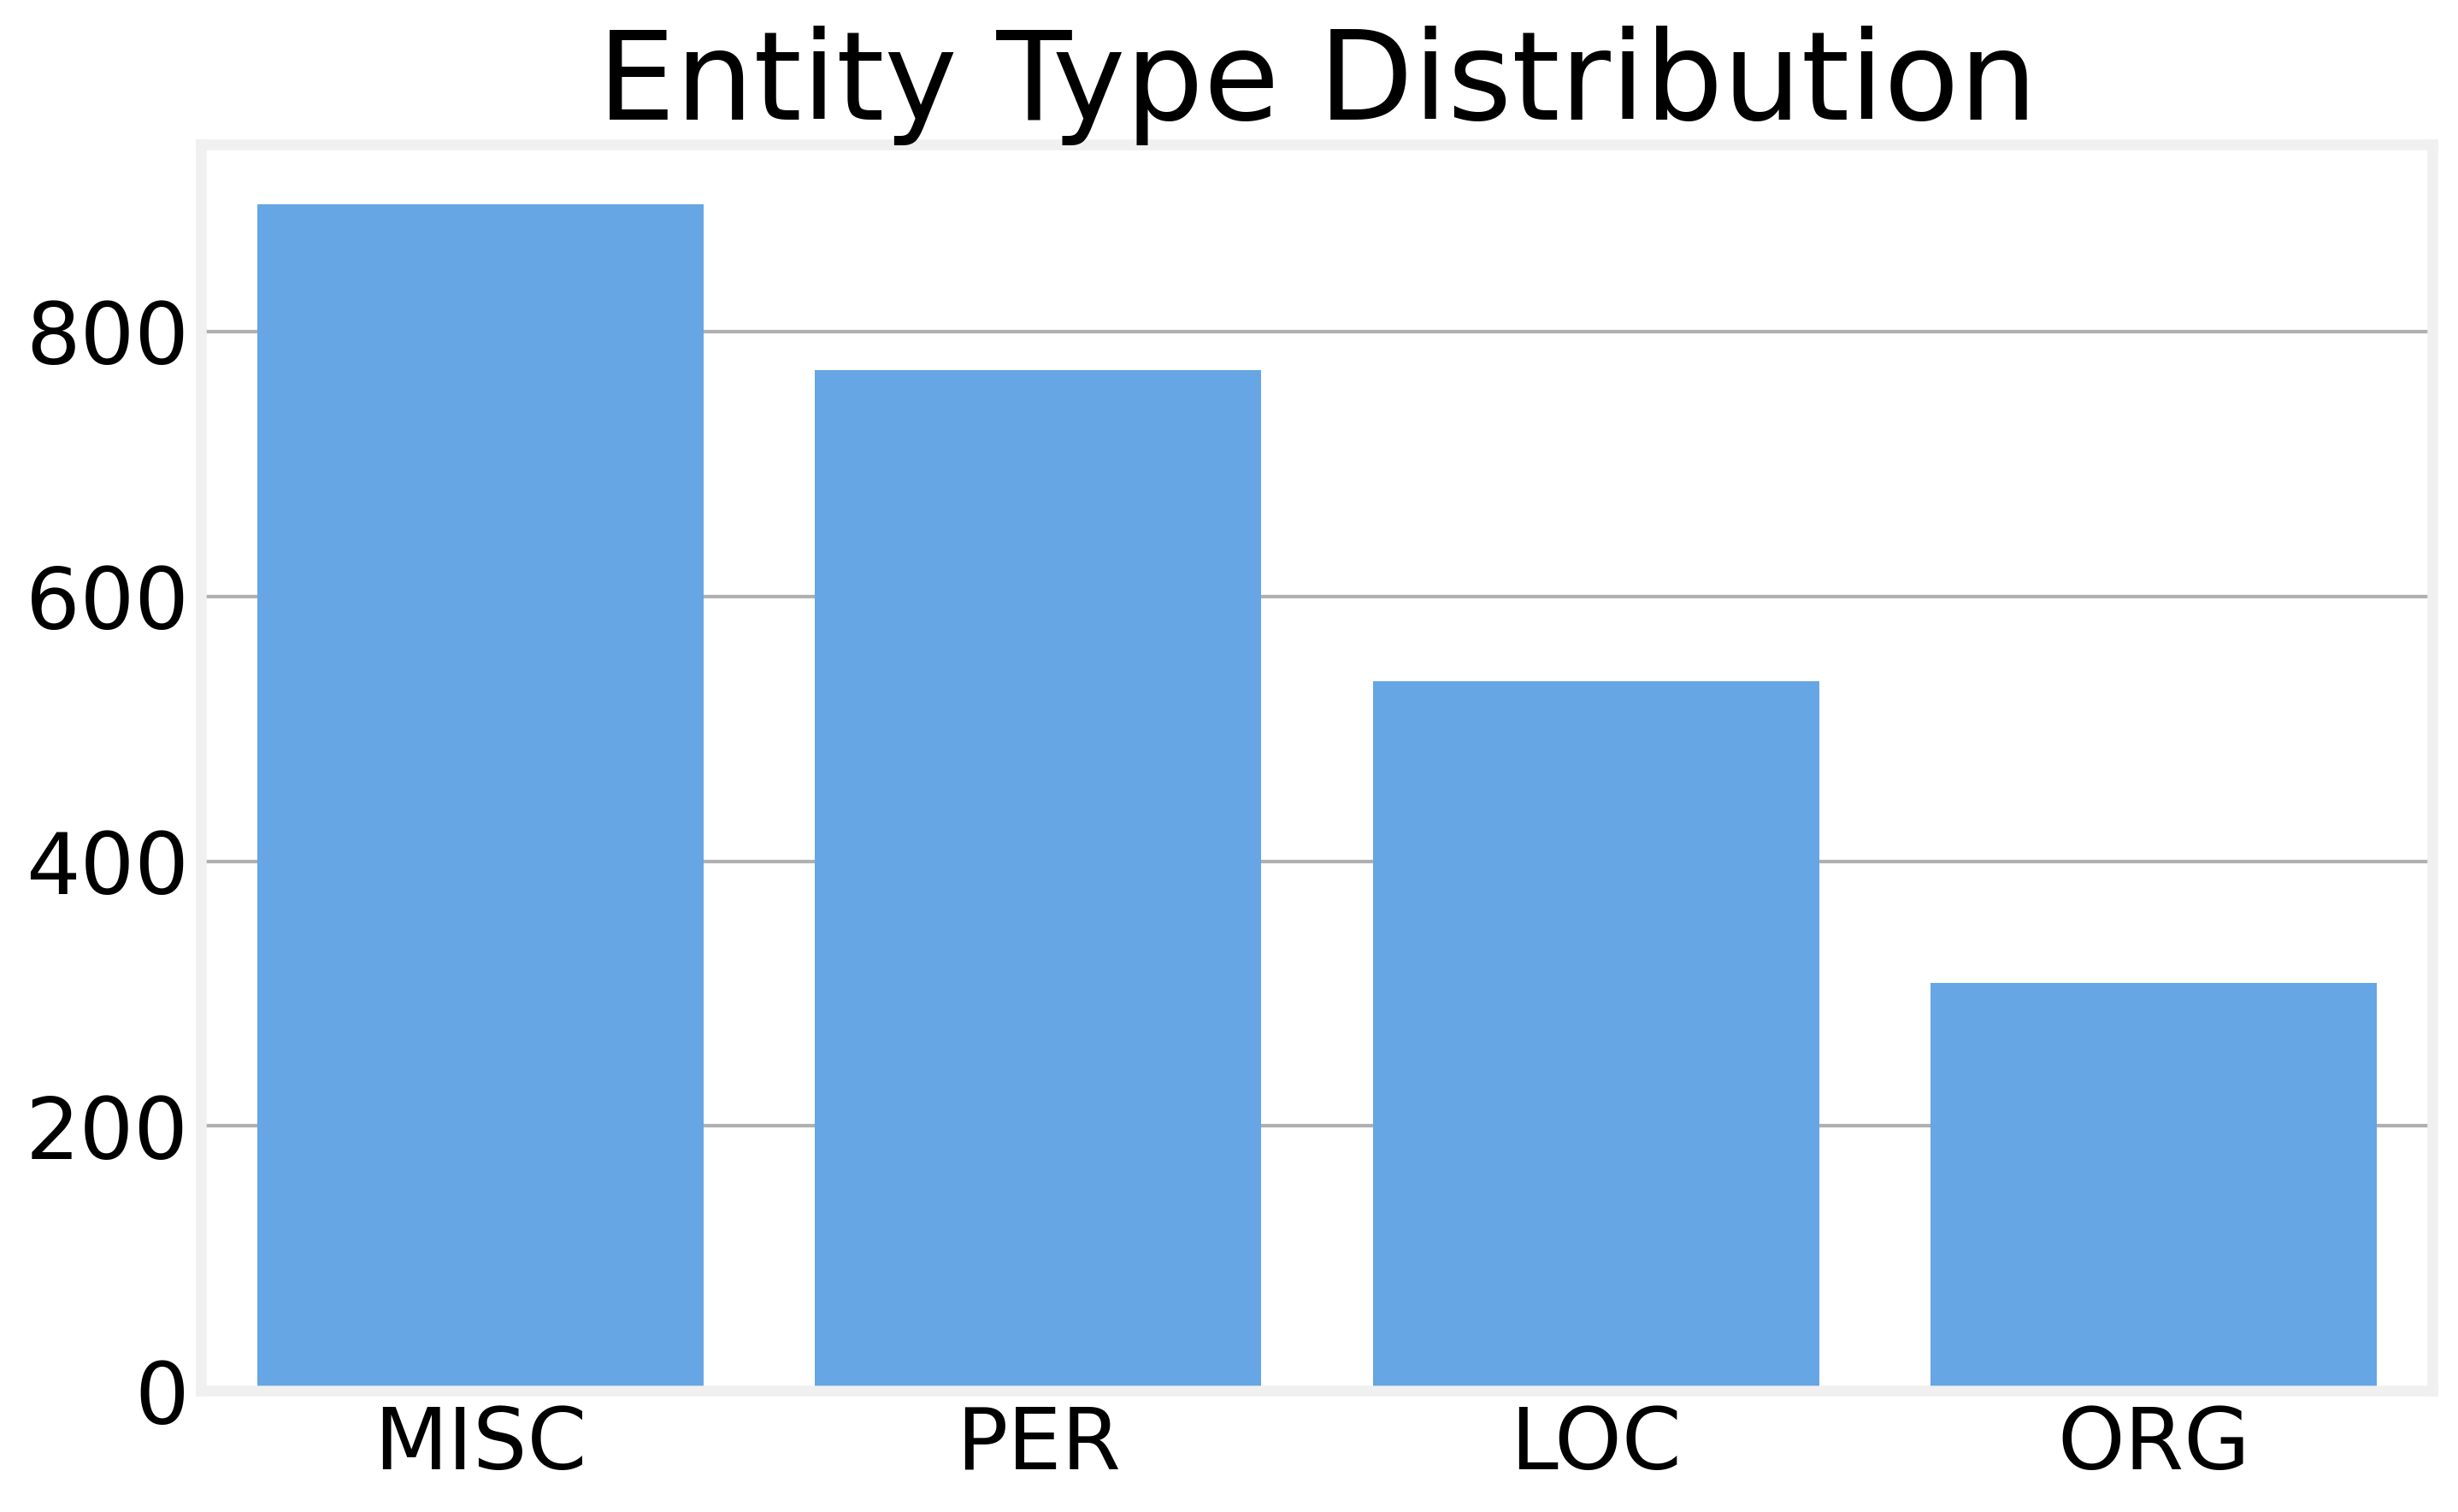

In [10]:
labels = [ent[1] for ent in all_entities]
label_counts = Counter(labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Entity Type Distribution")
plt.show()

---
## Summary of the results

This notebook performed an exploratory data analysis on the drug usage classification dataset.

*   **Step 1: Load Data**: The dataset was successfully loaded, containing **3000** rows and **12** columns.
*   **Step 2: Basic Inspection**: We confirmed that the target variable `Categorization` is perfectly balanced (1500 POSITIVE, 1500 NEGATIVE) and critical columns have no missing values.
*   **Step 3: Text Length Analysis**: The distribution of tweet lengths was analyzed, showing the variability in text size across the corpus.
*   **Step 4: Most Common Words**: After removing Spanish stopwords, we identified the most frequent terms. This confirms the presence of domain-specific (drug-related) terminology both classes.
